# Matrix-based scaling experiment
> More scaling, this time with the matrix-based generator and solver

Updated Nov 29, 2022

In [1]:
import sys
sys.path.append('/home/phil/aptr')
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.simulation_new import make_tables
from src.database import RnaDB
from src.torch_solver import TorchSolver

In [3]:
rnadb = RnaDB(
    path_to_dnaA = "../../data/allDnaA.tsv",
    path_to_16s = "../../data/allSSU.tsv",
)

0.9992494370778083 sequences remain after trimming
0.6346009507130348 sequences remain after filtering


In [6]:
# This takes about 5 minutes for 100 samples
abundances, log2_ptrs, otus = make_tables(
    n_genomes=10,
    n_samples=20,
    db=rnadb,
    sparsity=0,
    multiplier=1
)

In [8]:
solver = TorchSolver(otus=otus, db=rnadb)

Using OTU index for md5s


In [12]:
def score(solver, true_abundances, true_log2_ptrs):
    inferred_ptrs = pd.DataFrame(
        data=solver.B_hat.exp().detach().numpy(),
        index=solver.genome_ids,
        columns=solver.sample_ids,
    )
    inferred_abundances = pd.DataFrame(
        data=solver.A_hat.detach().numpy(),
        index=solver.genome_ids,
        columns=solver.sample_ids,
    )
    true_ptrs = np.exp2(true_log2_ptrs).reindex(inferred_ptrs.index)
    true_abundances = true_abundances.reindex(inferred_abundances.index)

    ptr_score = true_ptrs - inferred_ptrs
    abundance_score = true_abundances - inferred_abundances
    return ptr_score, abundance_score, inferred_ptrs, inferred_abundances


# Effect of number of genomes

In [14]:
results = pd.DataFrame()
for n_genomes in range(1, 20):
    print(n_genomes)
    abundances, log2_ptrs, otus = make_tables(
        n_genomes=n_genomes,
        n_samples=20 - n_genomes,  # same number of samples for each
        db=rnadb,
        sparsity=0,
        multiplier=1,
    )
    solver = TorchSolver(otus=otus, db=rnadb)
    solver.train(lr=0.1, clip=True, model_bias=False)
    B_scores, A_scores, B_inf, A_inf = score(
        solver=solver,
        true_log2_ptrs=log2_ptrs,
        true_abundances=abundances,
    )
    for i, genome_id in enumerate(solver.genome_ids):
        for j, sample_id in enumerate(solver.sample_ids):
            try:
                results = results.append(
                    {
                        "n_genomes": n_genomes,
                        "genome": genome_id,
                        "sample": sample_id,
                        "true_ptr": np.exp2(log2_ptrs.loc[genome_id, sample_id]),
                        "inferred_ptr": B_inf.loc[genome_id, sample_id],
                        "inferred_abundance": A_inf.loc[genome_id, sample_id],
                        "abundance": log_abundances.loc[genome_id, sample_id],
                        "ptr_score": B_scores.loc[genome_id, sample_id],
                        "abundance_score": A_scores.loc[genome_id, sample_id],
                        "n_reads": otus.loc[
                            rnadb[genome_id]["md5"].unique(), sample_id
                        ].sum(),
                    },
                    ignore_index=True,
                )
            except Exception as e:
                print(e)

results


1
Using OTU index for md5s
Initial:	 -338.4758605957031
Epoch 0:	 -2463.898193359375
Epoch 1:	 -2713.03466796875
Epoch 2:	 -2855.485107421875
Epoch 3:	 -2953.6494140625
Epoch 4:	 -3026.158447265625
Epoch 5:	 -3080.958984375
Epoch 6:	 -3122.451171875
Epoch 7:	 -3153.647216796875
Epoch 8:	 -3176.734375
Epoch 9:	 -3193.843994140625
Epoch 10:	 -3206.75
Epoch 11:	 -3216.514892578125
Epoch 12:	 -3223.9599609375
Epoch 13:	 -3229.629638671875
Epoch 14:	 -3233.826171875
Epoch 15:	 -3236.81201171875
Epoch 16:	 -3238.815673828125
Epoch 17:	 -3240.041748046875
Epoch 18:	 -3240.685546875
Epoch 19:	 -3240.95263671875
Epoch 20:	 -3241.1455078125
Epoch 21:	 -3241.3203125
Epoch 22:	 -3241.45068359375
Epoch 23:	 -3241.531005859375
Epoch 24:	 -3241.56787109375
Epoch 25:	 -3241.580322265625
Epoch 26:	 -3241.58203125
Epoch 27:	 -3241.581787109375
Epoch 28:	 -3241.5810546875
Epoch 29:	 -3241.58203125
Epoch 30:	 -3241.581787109375
Epoch 31:	 -3241.58203125
Epoch 32:	 -3241.58056640625
'865938.3'
'865938.3'
'

Text(0.5, 0, '')

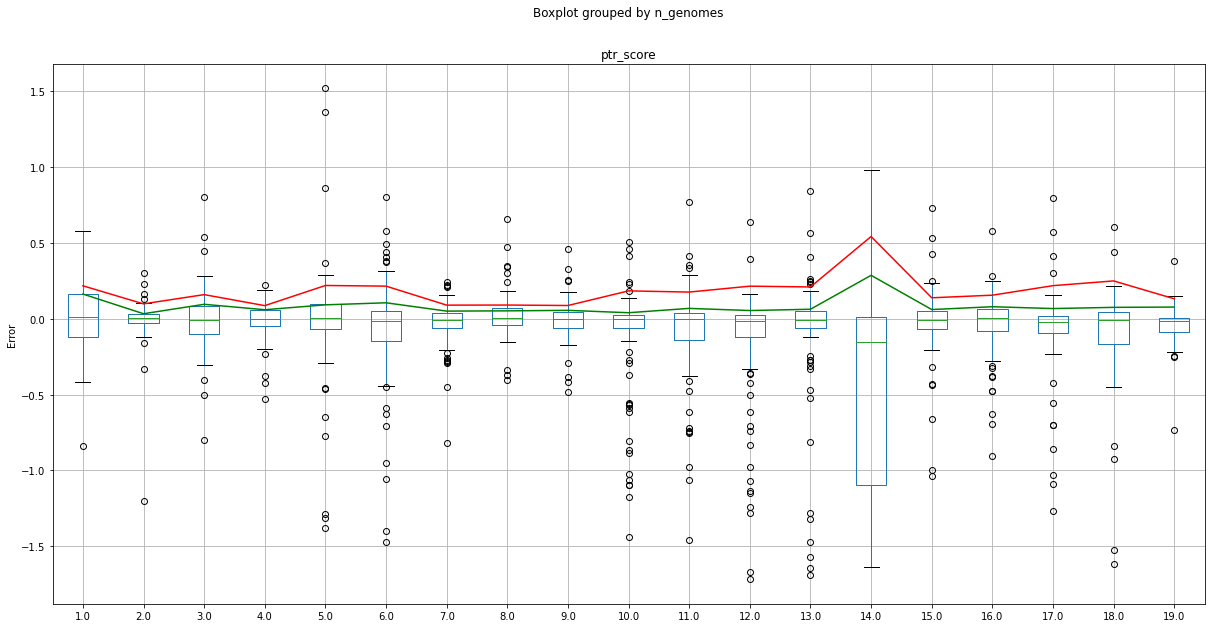

In [292]:
results.boxplot(by="n_genomes", column="ptr_score", figsize=(20, 10))

# Draw error on same figure with different y axis
plt.plot(np.arange(1, 20), results[["n_genomes", "ptr_score"]].abs().groupby("n_genomes").mean()["ptr_score"], c="red")
plt.plot(np.arange(1, 20), results[["n_genomes", "ptr_score"]].abs().groupby("n_genomes").median()["ptr_score"], c="green")
plt.ylabel("Error")
plt.xlabel("")

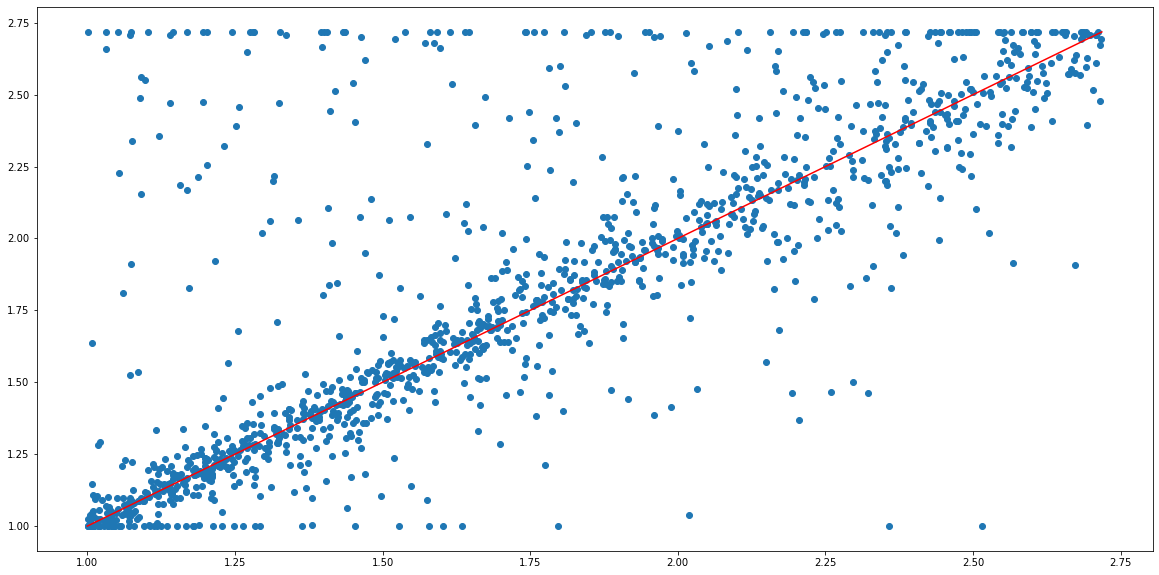

In [296]:
fig = plt.figure(figsize=(20, 10))
plt.scatter(results["true_ptr"], results["inferred_ptr"])
plt.plot([1,np.e], [1,np.e], c="red")

(array([1.323e+03, 3.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.02100000e+03, 4.08387666e+07, 8.16765123e+07, 1.22514258e+08,
        1.63352004e+08, 2.04189749e+08, 2.45027495e+08, 2.85865241e+08,
        3.26702986e+08, 3.67540732e+08, 4.08378478e+08, 4.49216223e+08,
        4.90053969e+08, 5.30891714e+08, 5.71729460e+08, 6.12567206e+08,
        6.53404951e+08, 6.94242697e+08, 7.35080443e+08, 7.75918188e+08,
        8.16755934e+08]),
 <BarContainer object of 20 artists>)

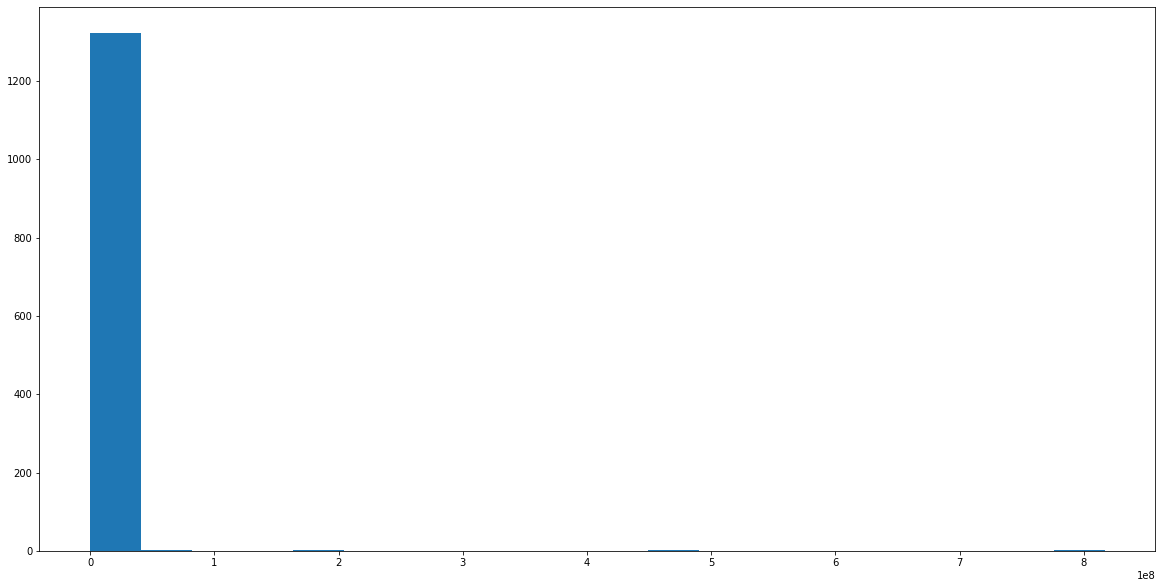

In [302]:
fig = plt.figure(figsize=(20, 10))
plt.hist(results["n_reads"], bins=20)

# Effect of scaling factor

In [308]:
results_scaling = pd.DataFrame()
for scaling_factor in range(-5, 0):
    print(scaling_factor)
    log_abundances, log_ptrs, otus = make_tables(
        n_genomes=5,
        n_samples=20,  # same number of samples for each
        db=rnadb,
        sparsity=0,
        multiplier=10**scaling_factor,
    )
    solver = TorchSolver(otus=otus, db=rnadb)
    try:
        solver.train(lr=0.1, clip=True)
    except Exception as e:
        print(e)
        continue
    B_scores, A_scores, B_inf, A_inf = score(
        solver=solver,
        true_log_ptrs=log_ptrs,
        true_log_abundances=log_abundances,
    )
    for i, genome_id in enumerate(solver.genome_ids):
        for j, sample_id in enumerate(solver.sample_ids):
            try:
                results_scaling = results_scaling.append(
                    {
                        "scaling": scaling_factor,
                        "genome": genome_id,
                        "sample": sample_id,
                        "true_ptr": np.exp(log_ptrs.loc[genome_id, sample_id]),
                        "inferred_ptr": B_inf.loc[genome_id, sample_id],
                        "inferred_abundance": A_inf.loc[genome_id, sample_id],
                        "abundance": np.exp(
                            log_abundances.loc[genome_id, sample_id]
                        ),
                        "ptr_score": B_scores.loc[genome_id, sample_id],
                        "abundance_score": A_scores.loc[genome_id, sample_id],
                        "n_reads": otus.loc[
                            rnadb[genome_id]["md5"].unique(), sample_id
                        ].sum(),
                    },
                    ignore_index=True,
                )
            except Exception as e:
                print(e)

results_scaling


-5
Using OTU index for md5s
Initial:	 nan
Epoch 0:	 nan
Epoch 1:	 nan
Epoch 2:	 nan
Epoch 3:	 nan
Epoch 4:	 nan
Epoch 5:	 nan
'NoneType' object has no attribute 'detach'
-4
Using OTU index for md5s
Initial:	 28.529497146606445
Epoch 0:	 0.0020536051597446203
Epoch 1:	 0.0020531127229332924
Epoch 2:	 0.002052998635917902
Epoch 3:	 0.002052947646006942
Epoch 4:	 0.002052920637652278
Epoch 5:	 0.0020529290195554495
Epoch 6:	 0.002052930649369955
Epoch 7:	 0.0020529041066765785
Epoch 8:	 0.0020529001485556364
Epoch 9:	 0.0020529339089989662
Epoch 10:	 0.002052938099950552
Epoch 11:	 0.0020529073663055897
Epoch 12:	 0.0020528987515717745
Epoch 13:	 0.002053008181974292
Epoch 14:	 0.0020529362373054028
Epoch 15:	 0.002052919939160347
Epoch 16:	 0.0020530163310468197
Epoch 17:	 0.0020528892055153847
Epoch 18:	 0.002052897587418556
Epoch 19:	 0.002052897587418556
Epoch 20:	 0.0020528959576040506
Epoch 21:	 0.002052888972684741
Epoch 22:	 0.0020529141183942556
Epoch 23:	 0.002052899682894349
Ep

,abundance,abundance_score,genome,inferred_abundance,inferred_ptr,n_reads,ptr_score,sample,scaling,true_ptr
0,1.382856,0.998886,1354791.3,0.383970,1.000004,0.0,1.715780,0.0,-4.0,2.715785
1,10.467466,10.444409,1354791.3,0.023057,1.009971,0.0,0.779026,1.0,-4.0,1.788996
2,1.682126,1.278734,1354791.3,0.403393,1.000316,0.0,0.258074,2.0,-4.0,1.258390
3,6888.976113,6829.462506,1354791.3,59.513607,2.718282,732.0,-0.006839,3.0,-4.0,2.711443
4,9.212483,9.204065,1354791.3,0.008418,2.718282,2.0,-0.653761,4.0,-4.0,2.064521
...,...,...,...,...,...,...,...,...,...,...
395,2.767365,2.068535,644283.4,0.698831,1.260484,557.0,0.348888,15.0,-1.0,1.609373
396,336.534499,322.764068,644283.4,13.770431,1.772980,65589.0,-0.023190,16.0,-1.0,1.749791
397,1.434001,1.316758,644283.4,0.117243,2.718282,229.0,-0.213618,17.0,-1.0,2.504664
398,185.039894,177.867159,644283.4,7.172735,1.223497,42010.0,-0.030803,18.0,-1.0,1.192694


<AxesSubplot:title={'center':'ptr_score'}, xlabel='scaling'>

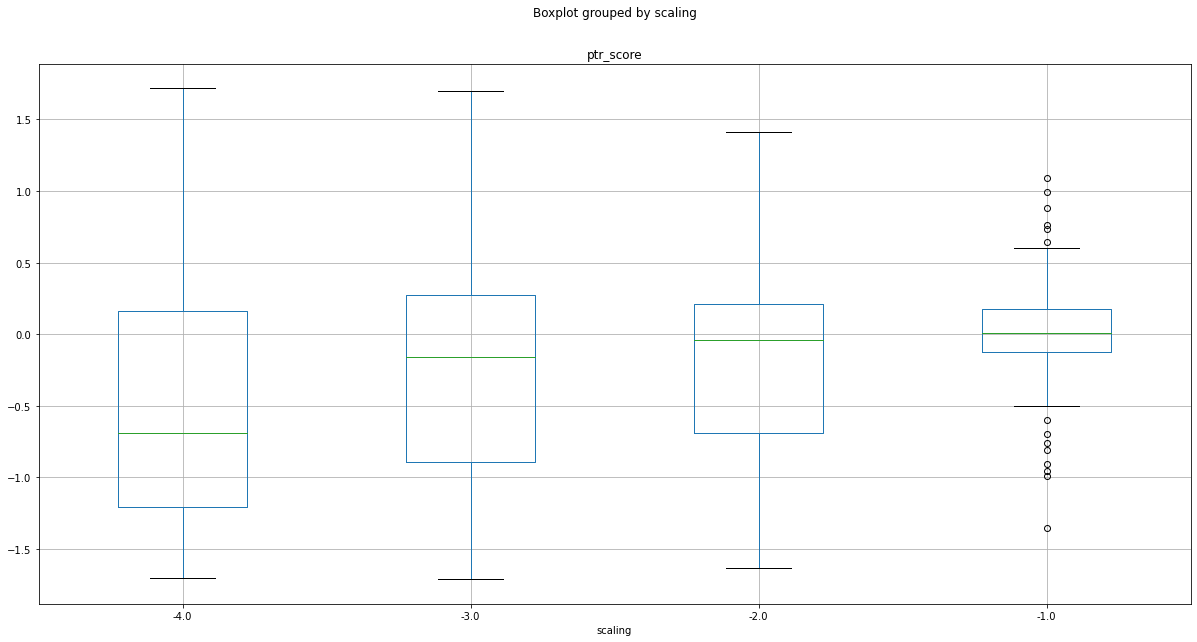

In [310]:
results_scaling.boxplot(by="scaling", column="ptr_score", figsize=(20, 10))

Text(0, 0.5, 'Error')

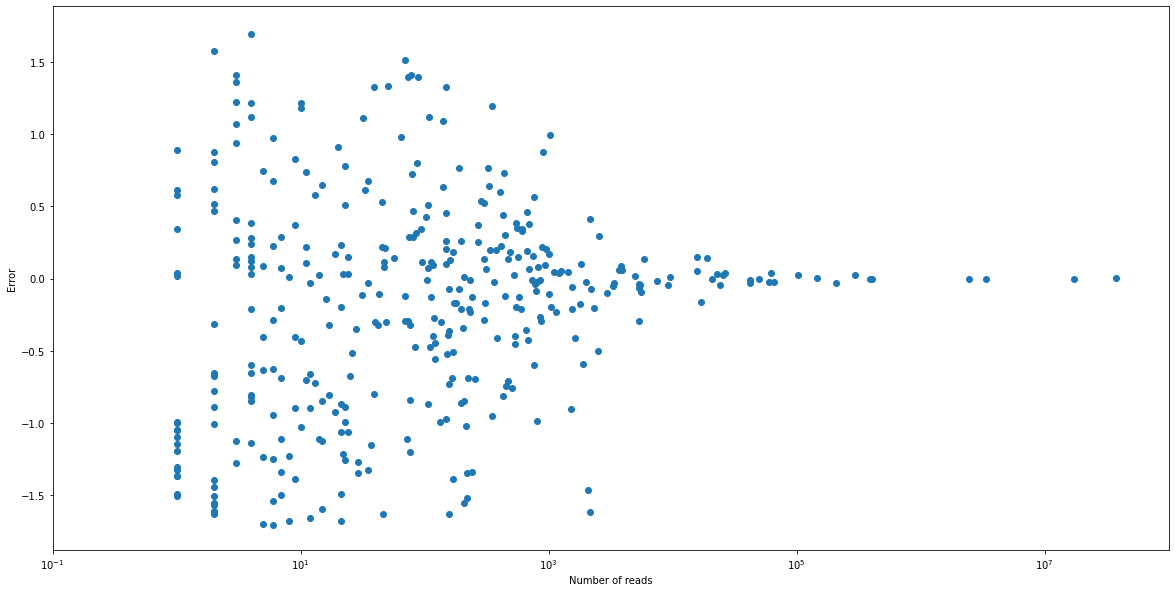

In [315]:
figure = plt.figure(figsize=(20, 10))

plt.scatter(results_scaling["n_reads"], results_scaling["ptr_score"])
plt.xscale("log")
plt.xlim([.1, 1e8])
plt.xlabel("Number of reads")
plt.ylabel("Error")